In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline

df = pd.read_csv("1429_1.csv")

In [40]:
df = df[['reviews.doRecommend', 'reviews.date', 'reviews.numHelpful', 'reviews.rating', 'reviews.text']]
df.columns = ['doRecommend', 'date', 'numHelpful', 'rating', 'text']

In [41]:
df.date = pd.to_datetime(df['date'], dayfirst= True)
df = df[df.date.notnull()]

df = df[df.text.notnull()]

df = df.fillna(value = {'numHelpful': 0})

df["senti"] = df["rating"]>=4
df["senti"] = df["senti"].replace([True , False] , [1 , 0])

In [42]:
import re
cleanup_re = re.compile('[^a-z\']+')
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    return sentence

df.loc[:,"Summary_Clean"] = df.loc[:,"text"].apply(cleanup)

df.loc[:,'doRecommend'] = df.loc[:,'doRecommend'].replace([True , False] , [1 , 0])

In [43]:
check =  df[df["rating"].isnull() | df["doRecommend"].isnull()]
senti = df[df["rating"].notnull() & df["doRecommend"].notnull()]

In [44]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vs_compound = []
vs_pos = []
vs_neu = []
vs_neg = []
reviewsList = senti['text'].values
analyzer = SentimentIntensityAnalyzer()
for index in range(len(reviewsList)):
    vader_scores = analyzer.polarity_scores(reviewsList[index])
    vs_compound.append(vader_scores['compound'])
    vs_pos.append(vader_scores['pos'])
    vs_neu.append(vader_scores['neu'])
    vs_neg.append(vader_scores['neg'])

df_new = pd.DataFrame({'compound':vs_compound, 'pos':vs_pos, 'neu':vs_neu, 'neg':vs_neg, 'date':senti['date'].values, 'numHelpful':senti['numHelpful'].values, 'senti':senti['senti'].values, 'text':senti['Summary_Clean'].values, 'doRecommend':senti['doRecommend'].values})

In [45]:
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
negation_words = set()
negative_regexp = re.compile(r'n\'t')
for word in stopwords:
    if negative_regexp.search(word):
        negation_words.add(word)
for word in negation_words:
    stopwords.remove(word)

In [46]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=2 ,stop_words=stopwords , ngram_range=(1,2))
tfidf_transformer = TfidfTransformer()

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_new["text"], df_new['senti'], test_size = 0.2)

X_train_counts = count_vect.fit_transform(X_train)        
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let', 'll', 're', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


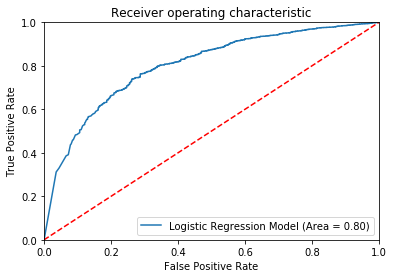

              precision    recall  f1-score   support

           0       0.69      0.26      0.38       470
           1       0.95      0.99      0.97      6344

   micro avg       0.94      0.94      0.94      6814
   macro avg       0.82      0.63      0.67      6814
weighted avg       0.93      0.94      0.93      6814

0.941150572351
0.941150572351
0.930280156771
0.928489474024
[[ 123  347]
 [  54 6290]]


In [67]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(solver='saga' , C=10)
logistic = logreg.fit(X_train_tfidf, y_train)
predictions = logreg.predict(X_test_tfidf)

y_predicted = model1.predict_proba(X_test_tfidf)[:, 1]
roc_auc = roc_auc_score(y_test, y_predicted)
fpr, tpr, _ = roc_curve(y_test, y_predicted)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression Model (Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,classification_report
print(classification_report(y_test, predictions))

print(accuracy_score(y_test,predictions))
print(recall_score(y_test,predictions,average='weighted'))
print(precision_score(y_test,predictions,average='weighted'))
print(f1_score(y_test,predictions,average='weighted'))


from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,predictions))

In [52]:
from sklearn.naive_bayes import MultinomialNB
model1 = MultinomialNB().fit(X_train_tfidf , y_train)
predictions = model1.predict(X_test_tfidf)

print(classification_report(y_test, predictions))

print(accuracy_score(y_test,predictions))
print(recall_score(y_test,predictions,average='weighted'))
print(precision_score(y_test,predictions,average='weighted'))
print(f1_score(y_test,predictions,average='weighted'))

print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       470
           1       0.93      1.00      0.96      6344

   micro avg       0.93      0.93      0.93      6814
   macro avg       0.47      0.50      0.48      6814
weighted avg       0.87      0.93      0.90      6814

0.930877604931
0.930877604931
0.866796936105
0.897695147174
[[   0  470]
 [   1 6343]]


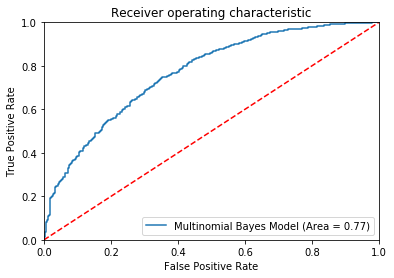

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       470
           1       0.93      1.00      0.96      6344

   micro avg       0.93      0.93      0.93      6814
   macro avg       0.47      0.50      0.48      6814
weighted avg       0.87      0.93      0.90      6814

0.930877604931
0.930877604931
0.866796936105
0.897695147174
[[   0  470]
 [   1 6343]]


In [63]:
from sklearn.naive_bayes import MultinomialNB
model1 = MultinomialNB().fit(X_train_tfidf , y_train)
predictions = model1.predict(X_test_tfidf)

from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt


y_predicted = model1.predict_proba(X_test_tfidf)[:, 1]
roc_auc = roc_auc_score(y_test, y_predicted)
fpr, tpr, _ = roc_curve(y_test, y_predicted)
plt.figure()
plt.plot(fpr, tpr, label='Multinomial Bayes Model (Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

print(classification_report(y_test, predictions))

print(accuracy_score(y_test,predictions))
print(recall_score(y_test,predictions,average='weighted'))
print(precision_score(y_test,predictions,average='weighted'))
print(f1_score(y_test,predictions,average='weighted'))

print(confusion_matrix(y_test,predictions))

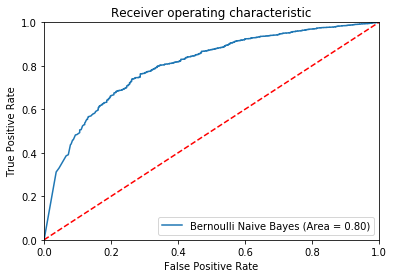

              precision    recall  f1-score   support

           0       0.33      0.15      0.21       470
           1       0.94      0.98      0.96      6344

   micro avg       0.92      0.92      0.92      6814
   macro avg       0.64      0.57      0.58      6814
weighted avg       0.90      0.92      0.91      6814

0.920311124156
0.920311124156
0.897741166001
0.906416668803
[[  72  398]
 [ 145 6199]]


In [65]:
from sklearn.naive_bayes import BernoulliNB
model1 = BernoulliNB().fit(X_train_tfidf , y_train)
predictions = model1.predict(X_test_tfidf)

y_predicted = model1.predict_proba(X_test_tfidf)[:, 1]
roc_auc = roc_auc_score(y_test, y_predicted)
fpr, tpr, _ = roc_curve(y_test, y_predicted)
plt.figure()
plt.plot(fpr, tpr, label='Bernoulli Naive Bayes (Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print(classification_report(y_test, predictions))

print(accuracy_score(y_test,predictions))
print(recall_score(y_test,predictions,average='weighted'))
print(precision_score(y_test,predictions,average='weighted'))
print(f1_score(y_test,predictions,average='weighted'))

print(confusion_matrix(y_test,predictions))